In [1]:
import folium
import pandas as pd
from zipfile import ZipFile
from sklearn.cluster import MiniBatchKMeans
import requests
import json
import collections
import spacy
%matplotlib inline
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords 
import re
from string import digits
from gensim.models import word2vec
from nltk.corpus import sentiwordnet as sw

In [2]:
lemmatizer=WordNetLemmatizer()
stemmer = PorterStemmer()
nlp = spacy.load('en_core_web_lg')
dublinersUrl = "https://raw.githubusercontent.com/JonathanReeve/course-computational-literary-analysis/gh-pages/_texts/dubliners.md"
dubliners = requests.get(dublinersUrl).text

In [3]:
dublinersDoc = nlp(dubliners.replace('\n',' '))

In [4]:
kmz = ZipFile("mappingdublinersearth.kmz", 'r')
kml = kmz.open('doc.kml', 'r').read()

In [5]:
kmlstr = str(kml)[1:]
aaa = kmlstr.replace('\\t','  ').split('\\n')
places = []
coordinates = {}
titles = []
routes = []
place_and_co = {}
for i in range(len(aaa)):
    if '<name>' in aaa[i]:
        if '&quot' in aaa[i]:
            storyName = aaa[i][16:-13]
            if storyName not in coordinates.keys():
                coordinates[storyName] = {}
                titles.append(storyName)
        else:
            placeName = aaa[i][12:-7].replace('&apos;',"'")
            places.append(placeName)
            
    if '<coordinates>' in aaa[i]:
        if placeName not in coordinates[storyName].keys():
            co = aaa[i][21:-16]
            co = co.split(',')
            if co[0] and len(co) == 2 or len(co) == 3:
                coordinates[storyName][placeName] = [float(co[1]),float(co[0])]
                place_and_co[placeName] = (float(co[1]),float(co[0]))
            if co[0]=='':
                routes.append(aaa[i+1])

In [6]:
placeSents = []
placeLabel = []
for sent in dublinersDoc.sents:
    placeinthissentence = []
    for place in places:
        if place in str(sent):
            placeinthissentence.append(place)
            if sent not in placeSents: 
                placeSents.append(sent)  
    if placeinthissentence:
        placeLabel.append(placeinthissentence)

In [7]:
lemmaList = []
for sent in placeSents: 
    sentLemmaList = []
    for w in sent: 
        if (not w.is_stop) and (not w.is_punct) and (not w.is_space) and (w.pos_ is not 'PROPN'): 
            sentLemmaList.append((w.lemma_, w.pos_))
    lemmaList.append(sentLemmaList)

In [8]:
placeScores = {}
placeSentScores = []
newPlaceLabel = []
for i in range(len(lemmaList)): 
    scores = []
    for word, pos in lemmaList[i]: 
        synPos = pos.lower()[0]
        if synPos not in ['a', 'n', 'v']:
            continue
        synsets = list(sw.senti_synsets(word, synPos))
        #print(synsets)
        if (type(synsets) == list) and len(synsets)>0:
            #print('yay!')
            synset = synsets[0]
            score = synset.pos_score() - synset.neg_score()
            scores.append(score)
    if len(scores)>0: 
        avgScores = sum(scores) / len(scores)
        placeSentScores.append(avgScores)
        for pp in placeLabel[i]:
            if pp in placeScores.keys():
                placeScores[pp].append(avgScores)
            else:
                placeScores[pp] = [avgScores]

In [9]:
for place in placeScores.keys():
    placeScores[place] = sum(placeScores[place])/len(placeScores[place])

In [10]:
df = pd.DataFrame([[place for place in placeScores.keys()],[score for score in placeScores.values()]],index=['place','score']).T

In [11]:
df

,place,score
0,Great Britain Street,-0.0625
1,Persia,0.0833333
2,Irishtown,0.0972222
3,Gardiner Street,0.0362103
4,Canal Bridge,0.0347222
5,Wharf Road,0.0208333
6,North Strand Road,0.0208333
7,Ringsend,0.0125
8,Buckingham Street,0.1
9,Westland Row,0


In [12]:
df = df.sort_values('score',ascending=False)

In [13]:
sentColors = ['maroon','firebrick','indianred','lightcoral','red','salmon','mistyrose']

In [14]:
coos = []
c1 = []
for i in range(len(df)):
    a = place_and_co[df['place'][i]]
    coos.append(a)
x = [coo[0] for coo in coos]
y = [coo[1] for coo in coos]

In [15]:
df[50:100]

,place,score
39,Hume Street,0.00520833
24,France,0.003125
87,Aungier Street,0
47,Merrion Street,0
77,Leghorn,0
114,Belgium,0
113,Germany,0
81,Sydney Parade Station,0
29,United States of America,0
28,Hungary,0


In [16]:
c = []
for color in sentColors:
    for i in range(18):
        c.append(color)
c = c[:124]

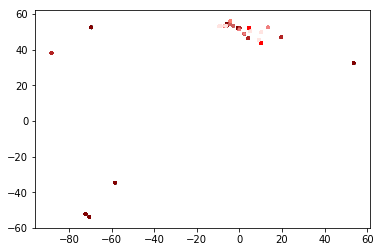

In [17]:
from pylab import *
for i in range(len(df)):
    scatter(y,x,s=5,c=c)
show()

In [18]:
color={'The Sisters':'teal',
       'An Encounter':'orange',
       'Araby':'yellow',
       'Eveline':'green',
       'After the Race':'cyan',
       'Two Gallants':'blue',
       'The Boarding House':'purple',
       'A Little Cloud':'pink',
       'Counterparts':'grey',
       'Clay':'black',
       'A Painful Case':'white',
       'Ivy Day in the Committee Room':'greenyellow',
       'A Mother':'chocolate',
       'Grace':'lavender',
       'The Dead':'olive'
        }

In [19]:
spots = []
for route in routes:
    tmp = []
    route_ = route.strip().split(' ')
    for spott in route_:
        spot = spott.split(',')
        tmp.append((float(spot[1]),float(spot[0])))
    spots.append(tmp)

In [20]:
spots[0]

[(53.35797000818081, -6.250030002093018),
 (53.3573352206858, -6.249143951214849),
 (53.35750045644036, -6.248725647725653),
 (53.35779821459258, -6.248101877144975),
 (53.35790570241438, -6.24786674556311),
 (53.35795517028548, -6.247702462865044),
 (53.35809577236208, -6.247494031563077),
 (53.3579860366565, -6.247285223634869),
 (53.35758425523001, -6.246436066915708),
 (53.35705389352371, -6.2454436951949),
 (53.35686043293271, -6.245115008381143),
 (53.35673894609435, -6.244978560257554),
 (53.35659875947859, -6.244705948273047),
 (53.35654239965567, -6.244621970760943),
 (53.35649915699585, -6.244564313813436),
 (53.35645119893908, -6.244516284616378),
 (53.35650019214522, -6.244422069341604),
 (53.35656833151774, -6.244341711287484),
 (53.35664238813025, -6.244258456201729),
 (53.35671113986401, -6.244134743795),
 (53.35675581050896, -6.244060179788771),
 (53.35680846732532, -6.243985227483728),
 (53.35693878228999, -6.243809251129999),
 (53.35707837238714, -6.243582354340543),


In [21]:
titles = ['The Sisters',
 'An Encounter',
 'Araby',
 'Eveline',
 'After the Race',
 'Two Gallants',
 'The Boarding House',
 'A Little Cloud',
 'Counterparts',
 'Clay',
 'A Painful Case',
 'Ivy Day in the Committee Room',
 'A Mother',
 'Grace',
 'The Dead']
centers = []
centerdict = {}
for title in titles:
    list = []
    for coordinate in coordinates[title].values():
        if coordinate[0]>53.254239 and coordinate[0]<53.414464 and coordinate[1]>-6.425699 and coordinate[1]<-6.112838:
            list.append((coordinate[0],coordinate[1]))
    clu = MiniBatchKMeans(n_clusters = 1)
    center = clu.fit(list)
    centroids = clu.cluster_centers_ 
    centerdict[title] = centroids
    centers.append(centroids)

In [22]:
'''
故事主要发生在哪点
'''
all_ = []
for title in titles:
    for coordinate in coordinates[title].values():
        if coordinate[0]>53.254239 and coordinate[0]<53.414464 and coordinate[1]>-6.425699 and coordinate[1]<-6.112838:
            all_.append((coordinate[0],coordinate[1]))
clu = MiniBatchKMeans(n_clusters = 1)
center = clu.fit(all_)
centroids = clu.cluster_centers_ 
print(centroids)

[[53.34327113 -6.25857278]]


In [24]:
from folium import plugins
world_map = folium.Map()
places = folium.map.FeatureGroup()
sentplace = folium.map.FeatureGroup()
pls = plugins.MarkerCluster()
routesColor = ['orange','yellow','cyan','cyan','blue','pink','grey','black','lavender','olive']

for i in range(len(spots)-1):
    for j in range(len(spots[i])-1):
        places.add_child(folium.PolyLine([(spots[i][j][0], spots[i][j][1]),(spots[i][j+1][0], spots[i][j+1][1])],color=routesColor[i]))

for i in centerdict.keys():
    places.add_child( folium.CircleMarker([centerdict[i][0][0], centerdict[i][0][1]], radius=20, # define how big you want the circle markers to be 
                                             color=color[i], fill=True, fill_color=color[i], fill_opacity=0.2, popup=i ))

for chapter in coordinates.keys():
    first = 0
    for place in coordinates[chapter].keys():
        if first == 0:
            places.add_child( folium.CircleMarker( [coordinates[chapter][place][0], coordinates[chapter][place][1]], radius=7, # define how big you want the circle markers to be 
                                             color=color[chapter], fill=False,popup=chapter+':'+'first one '+place ) )
            pls.add_child( folium.CircleMarker( [coordinates[chapter][place][0], coordinates[chapter][place][1]], radius=10, # define how big you want the circle markers to be 
                                             color=color[chapter], fill=False) )
            
        elif first == len(coordinates[chapter]) - 1:
            places.add_child( folium.CircleMarker( [coordinates[chapter][place][0], coordinates[chapter][place][1]], radius=7, # define how big you want the circle markers to be 
                                             color=color[chapter], fill=True, fill_color=color[chapter], fill_opacity=1,popup=chapter+':'+'last one '+place ) )
            pls.add_child( folium.CircleMarker( [coordinates[chapter][place][0], coordinates[chapter][place][1]], radius=10, # define how big you want the circle markers to be 
                                             color=color[chapter], fill=False) )
            
        else:
            places.add_child( folium.CircleMarker( [coordinates[chapter][place][0], coordinates[chapter][place][1]], radius=3, # define how big you want the circle markers to be 
                                             color=color[chapter], fill=True, fill_color=color[chapter], fill_opacity=first*1/(len(coordinates[chapter])-1),popup=chapter+':'+place ) ) 
            pls.add_child( folium.CircleMarker( [coordinates[chapter][place][0], coordinates[chapter][place][1]], radius=3, # define how big you want the circle markers to be 
                                             color=color[chapter], fill=False) ) 
        first += 1

for i in range(len(coos)):
    sentplace.add_child( folium.CircleMarker( [coos[i][0], coos[i][1]], radius=15, # define how big you want the circle markers to be 
                                             color=c[i], fill=True, fill_color=c[i], fill_opacity=0.5  ) )
 
        






irish_map = folium.Map(location=[53.34346921, -6.25834564], zoom_start=12)
irish_map.add_child(folium.Marker([53.34346921, -6.25834564], popup='center'))
irish_map.add_child(sentplace)
irish_map.add_child(places)
#irish_map.add_child(pls)
#sent_map.add_child(sentplace)

In [25]:
irish_map